In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [7]:
# Step 1: load the dataset
df = pd.read_csv("Dataset_Uber Traffic.csv")
df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [8]:
df.shape

(48120, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [10]:
# Step 2: Data Cleaning

# Convert 'DateTime' to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'], format="%d/%m/%y %H:%M")

# Drop duplicates if any
df = df.drop_duplicates()

# Check for missing values and handle them (here, we'll just drop if any)
df = df.dropna()

# Drop 'ID' column if not needed
df = df.drop(columns=['ID'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


In [11]:
# Step 3: Aggregate traffic data hourly per junction

data_aggregated = df.groupby(['DateTime', 'Junction']).agg({'Vehicles': 'sum'}).reset_index()


In [12]:
# Extract date and time features
data_aggregated['Hour'] = data_aggregated['DateTime'].dt.hour
data_aggregated['Day'] = data_aggregated['DateTime'].dt.day
data_aggregated['Weekday'] = data_aggregated['DateTime'].dt.weekday
data_aggregated['Month'] = data_aggregated['DateTime'].dt.month
data_aggregated['Year'] = data_aggregated['DateTime'].dt.year

# Lag features
data_aggregated['Lag_1hr'] = data_aggregated.groupby('Junction')['Vehicles'].shift(1)
data_aggregated['Lag_24hr'] = data_aggregated.groupby('Junction')['Vehicles'].shift(24)

# Weekend flag
data_aggregated['IsWeekend'] = data_aggregated['Weekday'].isin([5, 6]).astype(int)

# Drop NA values caused by lagging
data_aggregated.dropna(inplace=True)

In [13]:
# Define the feature columns
feature_cols = ['Hour', 'Day', 'Weekday', 'Month', 'Year', 'Junction', 'IsWeekend', 'Lag_1hr', 'Lag_24hr']

# Extract features
X = data_aggregated[feature_cols]
Y = data_aggregated['Vehicles']
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
data_aggregated.shape

(48024, 11)

In [15]:
data_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48024 entries, 72 to 48119
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DateTime   48024 non-null  datetime64[ns]
 1   Junction   48024 non-null  int64         
 2   Vehicles   48024 non-null  int64         
 3   Hour       48024 non-null  int32         
 4   Day        48024 non-null  int32         
 5   Weekday    48024 non-null  int32         
 6   Month      48024 non-null  int32         
 7   Year       48024 non-null  int32         
 8   Lag_1hr    48024 non-null  float64       
 9   Lag_24hr   48024 non-null  float64       
 10  IsWeekend  48024 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(6), int64(2)
memory usage: 3.3 MB


In [16]:
# Finding the NaN values in each columns
data_aggregated.isnull().sum()

DateTime     0
Junction     0
Vehicles     0
Hour         0
Day          0
Weekday      0
Month        0
Year         0
Lag_1hr      0
Lag_24hr     0
IsWeekend    0
dtype: int64

In [17]:
# Calculate the correlation matrix
correlation_matrix = data_aggregated[['Junction', 'Hour', 'Day', 'Weekday', 'Month', 
                                                'Year', 'Lag_1hr', 'Lag_24hr', 'IsWeekend']].corr()

correlation_matrix.head()


,Junction,Hour,Day,Weekday,Month,Year,Lag_1hr,Lag_24hr,IsWeekend
Junction,1.000000e+00,-4.946941e-16,-9.935785e-04,-1.657164e-03,-1.230177e-01,2.207096e-01,-0.614185,-0.613890,-2.099867e-03
Hour,-4.946941e-16,1.000000e+00,-1.616984e-16,1.651634e-17,1.483313e-15,7.941649e-15,0.200565,0.219917,2.164045e-17
Day,-9.935785e-04,-1.616984e-16,1.000000e+00,4.183192e-03,1.166212e-02,-1.172938e-02,0.025437,0.025346,8.193266e-03
Weekday,-1.657164e-03,1.651634e-17,4.183192e-03,1.000000e+00,-5.431359e-03,5.059544e-03,-0.120821,0.009410,7.891759e-01
Month,-1.230177e-01,1.483313e-15,1.166212e-02,-5.431359e-03,1.000000e+00,-6.217062e-01,-0.021698,-0.018188,-7.949083e-03


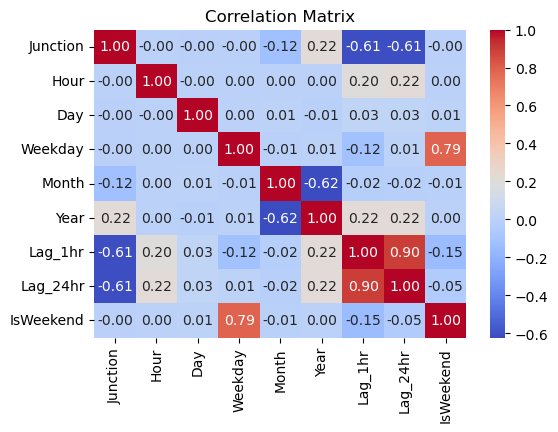

In [18]:
# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [20]:
data_aggregated.to_csv("Traffic_New.csv")